<a href="https://colab.research.google.com/github/Aritro30/CPSC-533R-Visual-AI-Assignment-2/blob/main/CPSC533R_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPSC 533R Visual AI - Assignment 2

This Jupyter notebook provides downloads and defines a pytorch dataset of egocentric images and corresponding 2D pose, a pre-defined neural network, and plotting utility functions. We also provide training code for regressing 2D pose directly from the image. All modules should seamlessly integrate into your Assignment 1 solution as they use dictionaries for storing the input images and output labels. It is your task to extend this notebook with the tasks described in the Assignment2.pdf.

In [1]:
# download dataset from the web (400 MB file from https://www.cs.ubc.ca/~rhodin/20_CPSC_532R_533R/assignments/EgoCap_nth10.hdf5)
file_name = "EgoCap_nth10.hdf5"
import os.path
import urllib.request
if not os.path.exists(file_name):
    print("Downloading dataset, might take a while... its 400 MB")
    urllib.request.urlretrieve("https://www.cs.ubc.ca/~rhodin/20_CPSC_532R_533R/assignments/"+file_name, file_name)
    print("Done downloading")
else:
    print("Dataset already present, nothing to be done")

Done downloading


In [2]:
# a function to move tensors from the CPU to the GPU
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

In [3]:
# Definition the EgoCap dataset (small version)
import torch
import torchvision
import torchvision.transforms as transforms
import h5py
import os

class EgoCapDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder):
        super(EgoCapDataset).__init__();
        data_file = 'EgoCap_nth10.hdf5'
        print("Loading dataset to memory, can take some seconds")
        with h5py.File(data_file, 'r') as hf:
            self.poses_2d = torch.from_numpy(hf['pose_2d'][...])
            self.poses_3d = torch.from_numpy(hf['pose_3d'][...])
            self.imgs  = torch.from_numpy(hf['img'][...])
        print(".. done loading")
        self.mean, self.std = torch.FloatTensor([0.485, 0.456, 0.406]), torch.FloatTensor([0.229, 0.224, 0.225])
        self.normalize = transforms.Normalize(self.mean, self.std)
        self.denormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/self.std),
                                               transforms.Normalize(mean = -self.mean, std = [ 1., 1., 1. ])])

    def __len__(self):
        return self.poses_2d.shape[0]
    
    def __getitem__(self, idx):
        sample = {'img': self.normalize(self.imgs[idx].float()/255),
                  'pose_2d': self.poses_2d[idx],
                  'pose_3d': self.poses_3d[idx]}
        return sample

In [4]:
# skeleton pose definition
# Labels are 2D (x, y) coordinate vectors, zero-based starting from the top-left pixel. They appear in the following order: 
joint_names = ['head', 'neck', 'left-shoulder', 'left-elbow', 'left-wrist', 'left-finger', 'right-shoulder', 'right-elbow', 'right-wrist', 'right-finger', 'left-hip', 'left-knee', 'left-ankle', 'left-toe', 'right-hip', 'right-knee', 'right-ankle', 'right-toe']
# the skeleton is defined as a set of bones (pairs of skeleton joint indices):
bones_ego_str = [('head', 'neck'), ('neck', 'left-shoulder'), ('left-shoulder', 'left-elbow'), ('left-elbow', 'left-wrist'), ('left-wrist', 'left-finger'), ('neck', 'right-shoulder'), ('right-shoulder', 'right-elbow'), ('right-elbow', 'right-wrist'), ('right-wrist', 'right-finger'), 
                 ('left-shoulder', 'left-hip'), ('left-hip', 'left-knee'), ('left-knee', 'left-ankle'), ('left-ankle', 'left-toe'), ('right-shoulder', 'right-hip'), ('right-hip', 'right-knee'), ('right-knee', 'right-ankle'), ('right-ankle', 'right-toe'), ('right-shoulder', 'left-shoulder'), ('right-hip', 'left-hip')]
bones_ego_idx = [(joint_names.index(b[0]),joint_names.index(b[1])) for b in bones_ego_str]

In [5]:
# plotting utility functions
import matplotlib.pyplot as plt

r"""Plots skeleton pose on a matplotlib axis.

        Args:
            ax (Axis): plt axis to plot
            pose_2d (FloatTensor): tensor of keypoints, of shape K x 2
            bones (list): list of tuples, each tuple defining the keypoint indices to be connected by a bone 
        Returns:
            Module: self
"""
def plot_skeleton(ax, pose_2d, bones=bones_ego_idx, linewidth=2, linestyle='-', label=None):
    cmap = plt.get_cmap('hsv')
    for i, bone in enumerate(bones):
        color = cmap(bone[1] * cmap.N // len(joint_names)) # color according to second joint index
        if i!=0:
            label=None
        ax.plot(pose_2d[bone,0], pose_2d[bone,1], linestyle, color=color, linewidth=linewidth, label=label)

r"""Plots list of skeleton poses and image.

        Args:
            poses (list): list of pose tensors to be plotted
            ax (Axis): plt axis to plot
            bones (list): list of tuples, each tuple defining the keypoint indices to be connected by a bone 
        Returns:
            Module: self
"""
def plotPosesOnImage(poses, img, ax=plt, labels=None):
    img_pil = torchvision.transforms.ToPILImage()(img)
    img_size = torch.FloatTensor(img_pil.size)
    linestyles = ['-', '--', '-.', ':']
    for i, p in enumerate(poses):
        pose_px = p*img_size
        plot_skeleton(ax, pose_px, linestyle=linestyles[i%len(linestyles)], label=labels[i])
    ax.imshow(img_pil)

r"""Converts a multi channel heatmap to an RGB color representation for display.

        Args:
            heatmap (tensor): of size C X H x W
        Returns:
            image (tensor): of size 3 X H x W
"""
def heatmap2image(heatmap):
    C,H,W = heatmap.shape
    cmap = plt.get_cmap('hsv')
    img = torch.zeros(3,H,W).to(heatmap.device)
    for i in range(C):
        color = torch.FloatTensor(cmap(i * cmap.N // C)[:3]).reshape([-1,1,1]).to(heatmap.device)
        img = torch.max(img, color * heatmap[i]) # max in case of overlapping position of joints
    # heatmap and probability maps might have small maximum value. Normalize per channel to make each of them visible
    img_max, indices = torch.max(img,dim=-1,keepdim=True)
    img_max, indices = torch.max(img_max,dim=-2,keepdim=True)
    return img/img_max

In [6]:
# setting up the dataset and train/val splits
path='./'
ecds = EgoCapDataset(data_folder=path)

val_ratio = 0.2
val_size = int(len(ecds)*val_ratio)
indices_val = list(range(0, val_size))
indices_train = list(range(val_size, len(ecds)))

val_set   = torch.utils.data.Subset(ecds, indices_val)
train_set = torch.utils.data.Subset(ecds, indices_train)

Loading dataset to memory, can take some seconds
.. done loading


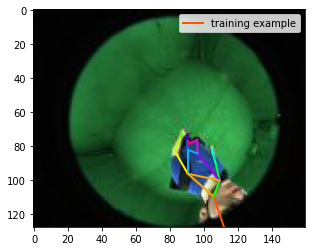

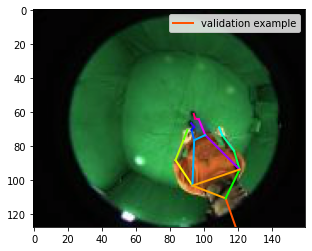

dataset length 7057
train_set length 5646
val_set length 1411
pose shape torch.Size([18, 2])
img shape torch.Size([3, 128, 160])


In [7]:
# playing with data and plotting functions
sample_train = train_set[100]
sample_val = val_set[100]
plotPosesOnImage([sample_train['pose_2d']], ecds.denormalize(sample_train['img']), labels=['training example'])
plt.legend()
plt.show()
plotPosesOnImage([sample_val['pose_2d']], ecds.denormalize(sample_val['img']), labels=['validation example'])
plt.legend()
plt.show()
print('dataset length', len(ecds))
print('train_set length', len(train_set))
print('val_set length', len(val_set))
print('pose shape',sample_train['pose_2d'].shape)
print('img shape',sample_train['img'].shape)

In [8]:
# define the dataset loader (batch size, shuffling, ...)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 2, num_workers=0, pin_memory=False, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 2, num_workers=0, pin_memory=False, shuffle=False, drop_last=False)

## Regression-based pose inference

We provide a baseline method that regresses 2D pose straight from the image. Make sure that it runs on your hardware and configuration.

In [9]:
# define a regression network that works on dictionaries
class RegressionNet(torch.nn.Module):
    def __init__(self, num_joints):
        super().__init__()
        self.num_joints = num_joints
        self.net = torchvision.models.resnet50(num_classes=num_joints*2)

    def forward(self, dictionary):
        return {'pose_2d' : self.net(dictionary['img']).reshape(-1,self.num_joints,2)}
num_joints = len(joint_names)
regression_network = RegressionNet(num_joints=num_joints).cuda()

In [ ]:
# training loop for regression
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(regression_network.parameters(), lr=0.001)


num_epochs = 2
losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    regression_network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = regression_network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        #print(pred['pose_2d'], batch_gpu['pose_2d'])
        loss = torch.nn.functional.mse_loss(pred['pose_2d'], batch_gpu['pose_2d'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if i%10==0:
            # clear figures for a new update
            for ax in axes:
                ax.cla()
            # plot the predicted pose and ground truth pose on the image
            plotPosesOnImage([pred_cpu['pose_2d'][0].detach(), 
                           batch_cpu['pose_2d'][0]], 
                          ecds.denormalize(batch_cpu['img'][0]), ax=axes[0], labels=['prediction','ground truth label'])
            axes[0].legend()
            axes[0].set_title('Input image with predicted pose (solid) and GT pose (dashed)')

            # plot the training error on a log plot
            axes[1].plot(losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), losses[-1]))
            print("Training for the specified amount of epochs would take long.\nStop the process once you verified that the training works on your setup.")
plt.close('all')

## Heatmap-based pose classification

In [10]:
# Detection network that handles dictionaries as input and output
class HeatNetWrapper(torch.nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, dictionary):
        return {'heatmap':(self.net(dictionary['img'])['out'])}
num_joints = len(joint_names)
det_network = HeatNetWrapper(torchvision.models.segmentation.deeplabv3_resnet50(num_classes=num_joints)).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
# Function that takes an NxKx2 pose vector (N: batch dimension, K: number of keypoints) to create stacks of heatmaps that have Gaussian distribution with the mean at the keypoint. 
# Determine a suitable standard deviation by visually inspecting the result and monitoring the training. Both, a too big and too small Gaussian size has drawbacks.
# The second argument specifies the output dimensions of the map. Note that the keypoints are defined in normalized coordinates, ranging from 0..1 irrespectively of the image resolution.
import math

r"""Creates a heatmap stack, with each channel having Gaussian form with mean at the pose keypoint locations

        Args:
            pose_2d (tensor): tensor of size N x K x 2, with K the number of keypoints. Keypoint locations store relative keypoint locations, i.e. both x and y coordinated in the range 0..1
            map_size (tuple): height and width of the heatmap to be generated
        Returns:
            heatmap (tensor): tensor of size N x K x H x W, with K the number of keypoints
"""
def pose2heatmap(pose_2d, map_size):

    # TODO: Task I
    N, K = pose_2d.shape[0], pose_2d.shape[1]
    H, W = map_size[0], map_size[1]
    heatmap = torch.zeros((N,K,H,W))
    for n in range(N):
      for k in range(K):
        mu_x = pose_2d[n][k][0]
        mu_y = pose_2d[n][k][1]
        sigma = 0.1
        x_list = torch.linspace(0,1,W)
        y_list = torch.linspace(0,1,H)
        f_of_x = torch.FloatTensor(H,W)
        mesh = torch.meshgrid(y_list, x_list) 
        d = (mesh[0].cuda() - mu_y)**2 + (mesh[1].cuda() - mu_x)**2
        c = 1/math.sqrt(2*math.pi)
        f_of_x = c*torch.exp(-d/(2*sigma**2))
        heatmap[n][k] = f_of_x

    return heatmap

r"""Takes a heatmap and returns the location of the maximum value in the heatmap

        Args:
            heatmap (tensor): tensor of size N x K x H x W, with K the number of keypoints
        Returns:
            pose (tensor): tensor of size N x K x 2, the 2D pose for each image in the batch
"""       
def heatmap2pose(heatmap):
    max_alongx, _ = torch.max(heatmap, dim=-1)
    max_alongy, _ = torch.max(heatmap, dim=-2)
    _, max_y_index= torch.max(max_alongx, dim=-1)
    _, max_x_index = torch.max(max_alongy, dim=-1)
    res_y, res_x = heatmap.shape[-2:]
    return torch.stack([max_x_index/float(res_x), max_y_index/float(res_y)],dim=-1)

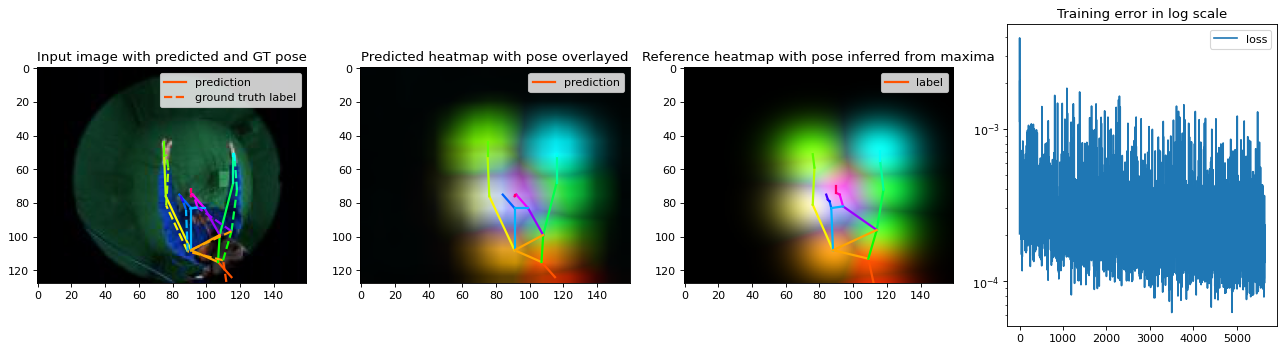

Epoch 1, iteration 2820 of 2823 (99 %), loss=0.00015421783609781414
Training for the specified amount of epochs would take long.
Stop the process once you verified that your method works.


In [ ]:
# training loop for heatmap prediction
%matplotlib inline
from IPython import display
optimizer = torch.optim.Adam(det_network.parameters(), lr=0.001)
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes=fig.subplots(1,4)
losses = []
num_epochs = 2
for e in range(num_epochs):
    train_iter = iter(train_loader)
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred_gpu = det_network(batch_gpu)
        pred_cpu = dict_to_device(pred_gpu, 'cpu')

        # convert between representations
        img_shape = batch_gpu['img'].shape
        gt_heatmap_gpu = pose2heatmap(batch_gpu['pose_2d'], img_shape[-2:])
        pred_pose = heatmap2pose(pred_cpu['heatmap']).cpu() # Note, not differentiable
        gt_pose_max = heatmap2pose(gt_heatmap_gpu).cpu()

        # optimize network
        loss = torch.nn.functional.mse_loss(pred_gpu['heatmap'].cuda(), gt_heatmap_gpu.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # display progress
        if i%10==0:
            # clear figure for a new update
            for ax in axes: 
                ax.cla()
            # plot the ground truth and the predicted pose on top of the image
            plotPosesOnImage([pred_pose[0], batch_cpu['pose_2d'][0]], ecds.denormalize(batch_cpu['img'][0]), ax=axes[0], labels=['prediction','ground truth label'])
            axes[0].set_title('Input image with predicted and GT pose')
            axes[0].legend()

            # plot the predicted heatmap map and the predicted pose on top
            plotPosesOnImage([pred_pose[0]], heatmap2image(pred_cpu['heatmap'][0]), ax=axes[1], labels=['prediction'])
            axes[1].set_title('Predicted heatmap with pose overlayed')
            axes[1].legend()

            # plot the reference heatmap map and the GT pose on top
            plotPosesOnImage([gt_pose_max[0]], heatmap2image(gt_heatmap_gpu[0].cpu()), ax=axes[2], labels=['label'])
            axes[2].set_title('Reference heatmap with pose inferred from maxima')
            axes[2].legend()

            # plot the current training error on a logplot
            axes[3].plot(losses, label='loss'); axes[3].set_yscale('log')
            axes[3].set_title('Training error in log scale')
            axes[3].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), losses[-1]))
            print("Training for the specified amount of epochs would take long.\nStop the process once you verified that your method works.")
plt.close('all')

## Integral pose regression via heatmaps

In [12]:
def integral_heatmap_layer(dict):
    N, K, H, W = dict['heatmap'].shape 
    # compute coordinate matrix
    heatmap = dict['heatmap'].view(N*K, H*W)
    softmax = torch.nn.Softmax(dim=-1)
    h_norm = softmax(heatmap)
    # TODO: Task II
    h_norm = h_norm.reshape(N, K, H, W)
    x_list = torch.linspace(0,1,W)
    y_list = torch.linspace(0,1,H)
    mesh = torch.meshgrid(y_list,x_list)
    x = torch.sum(mesh[1].cuda()*h_norm, dim = (2,3))
    y = torch.sum(mesh[0].cuda()*h_norm, dim = (2,3))
    pose = torch.stack((x,y), dim = -1)
    return {'probabilitymap': h_norm, 'pose_2d': pose}

In [13]:
int_network = HeatNetWrapper(torchvision.models.segmentation.deeplabv3_resnet50(num_classes=num_joints)).cuda()

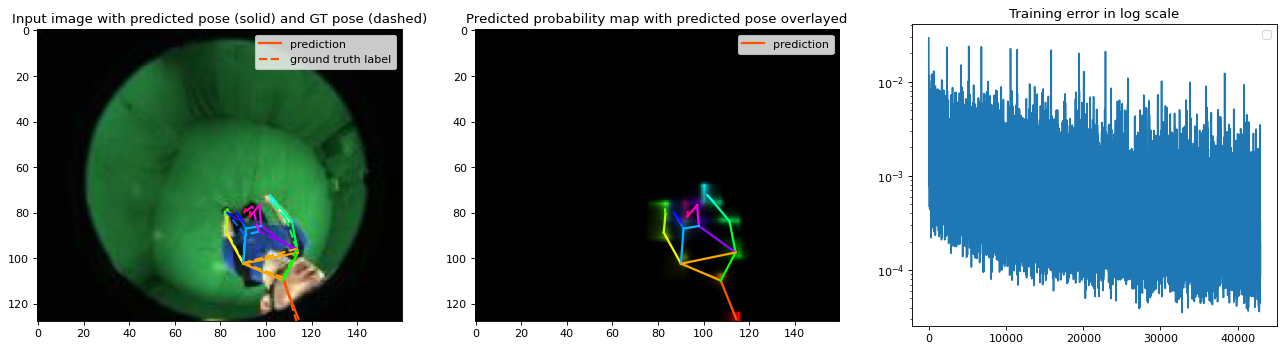

Epoch 15, iteration 580 of 2823 (20 %), loss=0.0003289624291937798
Training for the specified amount of epochs would take long.
Stop the process once you verified that your method works.


No handles with labels found to put in legend.


In [ ]:
%matplotlib inline
from IPython import display
import time
optimizer = torch.optim.Adam(int_network.parameters(), lr=0.001)
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes=fig.subplots(1,3)
losses = []
num_epochs = 100
for e in range(num_epochs):
    train_iter = iter(train_loader)
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred_raw = int_network(batch_gpu)
        pred_integral = integral_heatmap_layer(pred_raw) # note, this function must be differentiable

        # optimize network
        loss = torch.nn.functional.mse_loss(pred_integral['pose_2d'], batch_gpu['pose_2d'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # plot progress
        if i%10==0:
            # clear figures for a new update
            for ax in axes:
                ax.cla()
            pred_cpu = dict_to_device(pred_integral, 'cpu')
            # plot the ground truth and the predicted pose on top of the image
            plotPosesOnImage([pred_cpu['pose_2d'][0].detach(), batch_cpu['pose_2d'][0]], ecds.denormalize(batch_cpu['img'][0]), ax=axes[0], labels=['prediction', 'ground truth label'])
            axes[0].set_title('Input image with predicted pose (solid) and GT pose (dashed)')
            axes[0].legend()

            # plot the predicted probability map and the predicted pose on top
            plotPosesOnImage([pred_cpu['pose_2d'][0].detach()], heatmap2image(pred_cpu['probabilitymap'][0]).detach(), ax=axes[1], labels=['prediction'])
            axes[1].set_title('Predicted probability map with predicted pose overlayed')
            axes[1].legend()

            # plot the current training error on a logplot
            axes[2].plot(losses)
            axes[2].set_yscale('log')
            axes[2].set_title('Training error in log scale')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), losses[-1]))
            print("Training for the specified amount of epochs would take long.\nStop the process once you verified that your method works.")
plt.close('all')

### Comparison of 3 methods

In [14]:
# training loop for regression
%matplotlib inline
from IPython import display
# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)
optimizer = torch.optim.Adam(regression_network.parameters(), lr=0.001)
losses = []
val_losses = []
num_epochs = 5
for e in range(num_epochs):
    train_iter = iter(train_loader)
    regression_network = regression_network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = regression_network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        loss = torch.nn.functional.mse_loss(pred['pose_2d'], batch_gpu['pose_2d'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    total_err = []
    val_iter = iter(val_loader)
    regression_network = regression_network.eval()
    for j in range(len(val_loader)):
        batch_cpu_val = next(val_iter)
        batch_gpu_val = dict_to_device(batch_cpu_val, 'cuda')
        pred_val = regression_network(batch_gpu_val)
        pred_cpu_val = dict_to_device(pred_val, 'cpu') 
        error = torch.nn.functional.mse_loss(pred_val['pose_2d'], batch_gpu_val['pose_2d'])
        total_err.append(error.item())
            
    if True:
      print("MSE is", sum(total_err)/len(total_err))
plt.close('all')

MSE is 3.2163587416937407
MSE is 0.006593620055355132
MSE is 0.1489929672515794
MSE is 0.06530420552749878
MSE is 0.05767203470613384


In [ ]:
# training loop for heatmap prediction
%matplotlib inline
from IPython import display
optimizer = torch.optim.Adam(det_network.parameters(), lr=0.001)
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes=fig.subplots(1,4)
losses = []
num_epochs = 5
for e in range(num_epochs):
    train_iter = iter(train_loader)
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred_gpu = det_network(batch_gpu)
        pred_cpu = dict_to_device(pred_gpu, 'cpu')

        # convert between representations
        img_shape = batch_gpu['img'].shape
        gt_heatmap_gpu = pose2heatmap(batch_gpu['pose_2d'], img_shape[-2:])
        pred_pose = heatmap2pose(pred_cpu['heatmap']).cpu() # Note, not differentiable
        gt_pose_max = heatmap2pose(gt_heatmap_gpu).cpu()

        # optimize network
        loss = torch.nn.functional.mse_loss(pred_gpu['heatmap'].cuda(), gt_heatmap_gpu.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    det_network = det_network.eval()
    val_iter = iter(val_loader)
    total_err = []
    for j in range(len(val_loader)):
        batch_cpu_val = next(val_iter)
        batch_gpu_val = dict_to_device(batch_cpu_val, 'cuda')
        pred_gpu_val = det_network(batch_gpu_val)
        pred_cpu_val = dict_to_device(pred_gpu_val, 'cpu')

        # convert between representations
        img_shape_val = batch_gpu_val['img'].shape
        gt_heatmap_gpu_val = pose2heatmap(batch_gpu_val['pose_2d'], img_shape_val[-2:])
        pred_pose_val = heatmap2pose(pred_cpu_val['heatmap']).cpu() # Note, not differentiable
        gt_pose_max_val = heatmap2pose(gt_heatmap_gpu_val).cpu()

        error = torch.nn.functional.mse_loss(pred_gpu_val['heatmap'].cuda(), gt_heatmap_gpu_val.cuda())
        total_err.append(error.item())
            
    if True:
      print("MSE is", sum(total_err)/len(total_err))

        

plt.close('all')

MSE is 0.0004093749807405031
MSE is 0.0002509447366804565
MSE is 0.00023619268322157378
MSE is 0.00023583629577487105
MSE is 0.00024744752253259486


In [ ]:
%matplotlib inline
from IPython import display
import time
optimizer = torch.optim.Adam(int_network.parameters(), lr=0.001)
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes=fig.subplots(1,3)
losses = []
num_epochs = 5
for e in range(num_epochs):
    train_iter = iter(train_loader)
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred_raw = int_network(batch_gpu)
        pred_integral = integral_heatmap_layer(pred_raw) # note, this function must be differentiable

        # optimize network
        loss = torch.nn.functional.mse_loss(pred_integral['pose_2d'], batch_gpu['pose_2d'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    int_network = int_network.eval()
    total_err = []
    val_iter = iter(val_loader)
    for j in range(len(val_loader)):
        batch_cpu_val = next(val_iter)
        batch_gpu_val = dict_to_device(batch_cpu_val, 'cuda')
        pred_raw_val = int_network(batch_gpu_val)
        pred_integral_val = integral_heatmap_layer(pred_raw_val) # note, this function must be differentiable
        error = torch.nn.functional.mse_loss(pred_integral_val['pose_2d'], batch_gpu_val['pose_2d'])
        total_err.append(error.item())
            
    if True:
      print("MSE is", sum(total_err)/len(total_err))

        
        
plt.close('all')




/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Bonus Task: Can you implement a denisty network version of integral pose regression by estimating the std/sigma from the heatmap and using it for the probabilitic regression loss?

In [ ]:
# implement the bonus task here, with leaving the other code blocks unchanged for grading